# Local-friendly setup (VS Code / Windows)
This cell helps you confirm that you are running the notebook from the correct folder and that the dataset file is available locally.

**What it does:**
- Prints the current working directory (where Python is running from).
- Searches recursively for all `*.csv` files under the current folder.
- Prints the full path of each CSV file it finds.

**Why it’s useful:**
- Avoids Kaggle-only paths like `/kaggle/input/...` when running locally.
- Quickly verifies that `spam.csv` exists before calling `pd.read_csv('spam.csv', ...)`.

In [56]:
# Local-friendly setup (works in VS Code / Windows)
import os
from pathlib import Path

print('Current folder:', os.getcwd())
print('CSV files found:')
for p in Path('.').rglob('*.csv'):
    print(' -', p.resolve())

Current folder: d:\Codes\Website Of Codes\INTERNSHIP\Wagh
CSV files found:
 - D:\Codes\Website Of Codes\INTERNSHIP\Wagh\spam.csv


**Run the next cell first.** If you see `spam.csv` listed, the dataset is in the right place and the notebook can load it with `pd.read_csv('spam.csv', ...)`.

In [58]:
df = pd.read_csv('spam.csv', encoding='Windows-1252')

## Dataset size check
Shows the number of rows and columns in the dataset using `df.shape`.

In [59]:
df.shape

(5572, 5)

## Drop unused columns
Removes extra `Unnamed:*` columns that come with this CSV export and are not useful for modeling.

In [60]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

## Rename columns
Renames `v1` → `target` and `v2` → `text` to make the dataset easier to work with.

In [61]:
df = df.rename(columns={'v1' : 'target', 'v2' : 'text'})

## Encode target labels
Creates a `LabelEncoder` so the `target` column becomes numeric (ham/spam → 0/1).

In [62]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [63]:
df['target'] = encoder.fit_transform(df['target'])

In [64]:
df['target'].value_counts()

target
0    4825
1     747
Name: count, dtype: int64

## Data cleaning
Next we remove duplicate messages so the model isn’t trained/evaluated on repeated rows.

In [65]:
df.drop_duplicates(keep='first', inplace=True)

([<matplotlib.patches.Wedge at 0x26c2325b940>,
 [Text(-1.014499732282844, 0.4251944181172162, 'ham'),
  Text(1.0144998708287172, -0.42519408755122207, 'spam')],
 [Text(-0.5533634903360967, 0.2319242280639361, '87.37'),
  Text(0.553363565906573, -0.231924047755212, '12.63')])

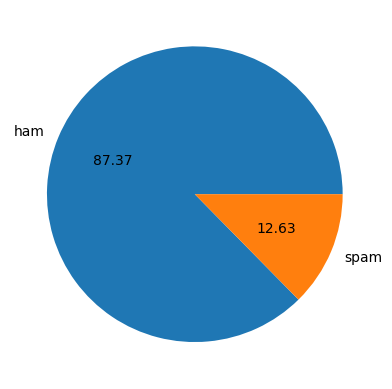

In [66]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")

In [67]:
import nltk 

In [68]:
df['num_characters']=df['text'].apply(len)

In [69]:
df['num_words']=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [70]:
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [71]:
df.describe()

,target,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455794,1.965564
std,0.332253,58.236293,13.324758,1.448541
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [72]:
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [73]:
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

# Ensure required NLTK data is available
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

ps = PorterStemmer()
_stopwords = set(stopwords.words('english'))
_punct = set(string.punctuation)

def transform_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)

    cleaned = []
    for token in tokens:
        if token.isalnum():
            cleaned.append(token)

    filtered = []
    for token in cleaned:
        if token not in _stopwords and token not in _punct:
            filtered.append(token)

    stemmed = [ps.stem(token) for token in filtered]
    return " ".join(stemmed)

In [74]:
df['transformed'] = df['text'].apply(transform_text)

In [75]:
from wordcloud import WordCloud
wc = WordCloud(width = 500, height=500, min_font_size = 10, background_color='black')


In [76]:
spam_wc=wc.generate(df[df['target'] == 1]['transformed'].str.cat(sep=" "))

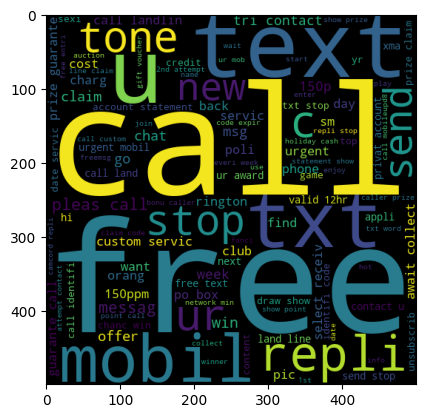

In [77]:
plt.imshow(spam_wc)

In [78]:
ham_wc=wc.generate(df[df['target'] == 0]['transformed'].str.cat(sep=" "))

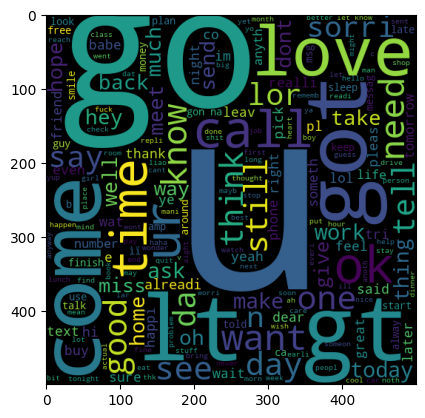

In [79]:
plt.imshow(ham_wc)

In [80]:
df.sample(5)

,target,text,num_characters,num_words,num_sentences,transformed
948,0,Chk in ur belovd ms dict,24,6,1,chk ur belovd ms dict
1782,0,My uncles in Atlanta. Wish you guys a great se...,53,12,2,uncl atlanta wish guy great semest
253,0,"Ups which is 3days also, and the shipping comp...",179,40,2,up 3day also ship compani take 2wk way usp tak...
1012,0,I dunno they close oredi not... ÌÏ v ma fan...,46,12,1,dunno close oredi ìï v fan
3472,0,You getting back any time soon?,31,7,1,get back time soon


In [82]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [83]:
X = tfidf.fit_transform(df['transformed']).toarray()

In [84]:
X.shape

(5169, 3000)

In [85]:
y = df['target'].values

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2)

In [88]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [89]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [91]:
mnb.fit(X_train, y_train)
y_pred1 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


In [92]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

In [93]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [94]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')

In [95]:
voting.fit(X_train, y_train)

,estimators,"[('svm', ...), ('nb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,1.0
,coef0,0.0


In [96]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9796905222437138
Precision 0.9834710743801653


In [97]:
# Improved accuracy + fast inference model (TF-IDF bigrams + ComplementNB)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import numpy as np
import time

# Make this cell runnable even if earlier cleaning cells weren't executed
work_df = df.copy()
cols = set(work_df.columns)

# Common Kaggle spam.csv format: v1=label, v2=text, plus extra unnamed columns
extra_cols = [c for c in ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'] if c in cols]
if extra_cols:
    work_df = work_df.drop(columns=extra_cols)

if {'v1', 'v2'}.issubset(work_df.columns) and not {'target', 'text'}.issubset(work_df.columns):
    work_df = work_df.rename(columns={'v1': 'target', 'v2': 'text'})

# Ensure target is 0/1
if work_df['target'].dtype == object:
    work_df['target'] = work_df['target'].map({'ham': 0, 'spam': 1}).astype('int64')

work_df = work_df.dropna(subset=['text', 'target'])
work_df = work_df.drop_duplicates(keep='first')

X_train, X_test, y_train, y_test = train_test_split(
    work_df['text'],
    work_df['target'],
    test_size=0.2,
    random_state=42,
    stratify=work_df['target'],
)

pipeline = Pipeline(
    steps=[
        (
            'tfidf',
            TfidfVectorizer(
                stop_words='english',
                lowercase=True,
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.95,
                sublinear_tf=True,
            ),
        ),
        ('clf', ComplementNB()),
    ]
 )

param_grid = {
    'clf__alpha': [0.1, 0.5, 1.0],
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='precision',  # keep spam precision high
    cv=5,
    n_jobs=-1,
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print('Best params:', grid.best_params_)

y_pred = best_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

# Quick inference timing (batch)
start = time.perf_counter()
_ = best_model.predict(X_test.iloc[:200])
elapsed_ms = (time.perf_counter() - start) * 1000
print(f'Predict 200 msgs: {elapsed_ms:.2f} ms')

Best params: {'clf__alpha': 1.0}
Accuracy: 0.9729206963249516
Precision: 0.8705035971223022
Confusion matrix:
 [[885  18]
 [ 10 121]]
Predict 200 msgs: 8.83 ms


In [98]:
# Save the best model in joblib, pickle (.pkl), and HDF5 (.h5)
import pickle
import joblib
import h5py
import numpy as np
from datetime import datetime

# 1) joblib (recommended for sklearn)
joblib.dump(best_model, 'spam_classifier.joblib')
print('Saved:', 'spam_classifier.joblib')

# 2) pickle (.pkl)
with open('spam_classifier.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print('Saved:', 'spam_classifier.pkl')

# 3) HDF5 (.h5) container storing the pickled bytes
payload = pickle.dumps(best_model)
with h5py.File('spam_classifier.h5', 'w') as f:
    f.create_dataset('sklearn_pipeline_pickle', data=np.void(payload))
    f.attrs['created_utc'] = datetime.utcnow().isoformat()
    f.attrs['format'] = 'pickle-in-hdf5'
print('Saved:', 'spam_classifier.h5')

Saved: spam_classifier.joblib
Saved: spam_classifier.pkl
Saved: spam_classifier.h5
